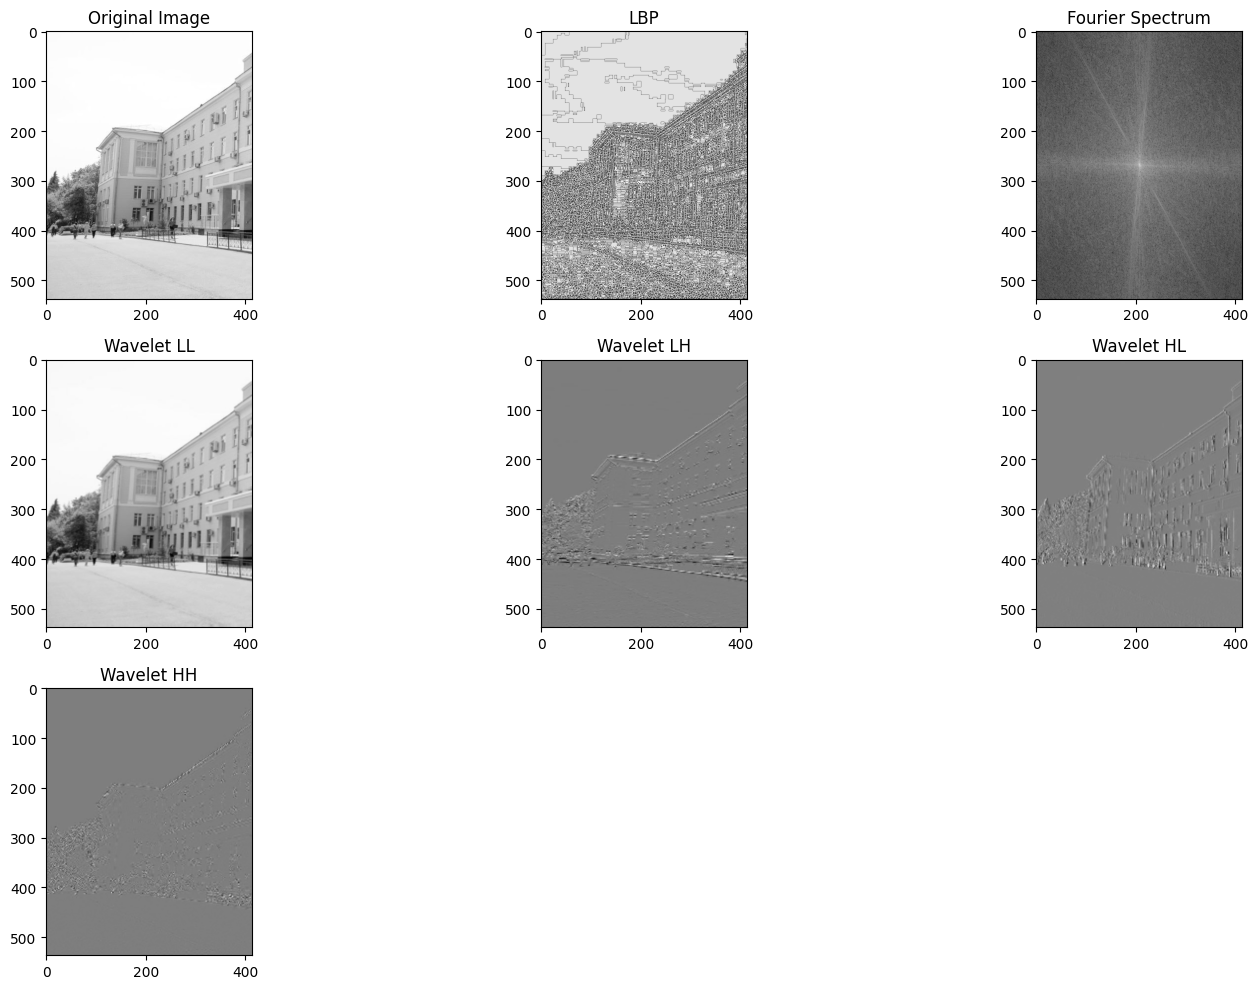

Первые 5x5 пикселей закодированного изображения:
 [[[  3.       153.1843   135.09175  502.         0.         0.
     0.      ]
  [  5.       153.1843   129.4227   502.         0.         0.
     0.      ]
  [  5.       153.1843   134.0569   502.         0.         0.
     0.      ]
  [  5.       153.1843   125.149536 502.         0.         0.
     0.      ]
  [  5.       153.1843   116.24404  502.         0.         0.
     0.      ]]

 [[  5.       153.1843   137.78569  502.         0.         0.
     0.      ]
  [  8.       153.1843   134.47343  502.         0.         0.
     0.      ]
  [  8.       153.1843   123.851135 502.         0.         0.
     0.      ]
  [  8.       153.1843   122.182884 502.         0.         0.
     0.      ]
  [  8.       153.1843   136.83646  502.         0.         0.
     0.      ]]

 [[  5.       153.1843   143.10866  502.         0.         0.
     0.      ]
  [  8.       153.1843   117.696106 502.         0.         0.
     0.      ]
  [  8.   

In [1]:
import numpy as np
import cv2
import pywt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

img_origin = cv2.imread('001.JPG')
img = cv2.cvtColor(img_origin, cv2.COLOR_BGR2GRAY)

# 1. Текстурные признаки

radius = 1
n_points = 8 * radius
lbp = local_binary_pattern(img, n_points, radius, method='uniform')

# Матрица взаимной встречаемости (GLCM)
distances = [1]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
glcm = graycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
contrast = graycoprops(glcm, 'contrast')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]

# Признаки Фурье
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

# Вейвлет-признаки
def compute_wavelet_features(image):
    coeffs2 = pywt.dwt2(image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    # Увеличиваем LL до исходного размера изображения с помощью интерполяции
    LL_resized = cv2.resize(LL, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    LH_resized = cv2.resize(LH, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    HL_resized = cv2.resize(HL, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    HH_resized = cv2.resize(HH, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    return LL_resized, LH_resized, HL_resized, HH_resized

LL, LH, HL, HH = compute_wavelet_features(img)

# Кодирование каждого пикселя
encoded_img = np.zeros((img.shape[0], img.shape[1], 7), dtype=np.float32)  # 7 признаков
encoded_img[:, :, 0] = lbp  # LBP
encoded_img[:, :, 1] = contrast  # GLCM (контраст)
encoded_img[:, :, 2] = magnitude_spectrum  # Фурье
encoded_img[:, :, 3] = LL  # Вейвлет LL
encoded_img[:, :, 4] = LH  # Вейвлет LH
encoded_img[:, :, 5] = HL  # Вейвлет HL
encoded_img[:, :, 6] = HH  # Вейвлет HH

# Визуализация
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1), plt.imshow(img, cmap='gray'), plt.title('Original Image')
plt.subplot(3, 3, 2), plt.imshow(lbp, cmap='gray'), plt.title('LBP')
plt.subplot(3, 3, 3), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title('Fourier Spectrum')
plt.subplot(3, 3, 4), plt.imshow(LL, cmap='gray'), plt.title('Wavelet LL')
plt.subplot(3, 3, 5), plt.imshow(LH, cmap='gray'), plt.title('Wavelet LH')
plt.subplot(3, 3, 6), plt.imshow(HL, cmap='gray'), plt.title('Wavelet HL')
plt.subplot(3, 3, 7), plt.imshow(HH, cmap='gray'), plt.title('Wavelet HH')
plt.tight_layout()
plt.show()

print("Первые 5x5 пикселей закодированного изображения:\n", encoded_img[:5, :5, :])



120
240
368
496
624
752
880
1008
1136
1264
1392
1520
1648
1776
1904
2032
2160
2288
2416
2544
2672
2800
2781
2509
2449
2397
2369
2306
2279
2280
2221
2115
1913
1697
1481
1285
1190
1111
1078
1032
989
944
902
855
813
750
666
602
358
122
0


(<Axes: title={'center': 'region_growing'}>,
 Text(0.5, 1.0, 'region_growing'))

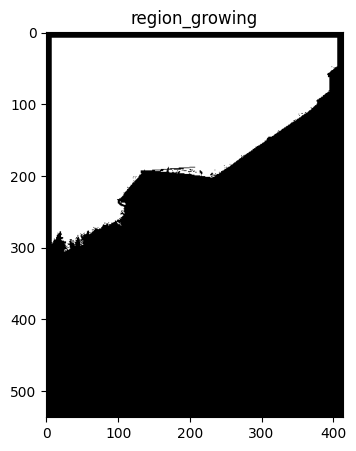

In [11]:
# 2. Сегментация изображения
#Алгоритм разрастания регионов
import math
img_origin = cv2.imread('001.JPG')
img = cv2.cvtColor(img_origin, cv2.COLOR_BGR2GRAY)
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False

def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(img.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(img.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask
        
    return mask*255
    
seed_point = (10, 10)
mask = region_growing(img,seed_point,homo_average, 8 , 10)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.imshow(mask, cmap="gray"), plt.title('region_growing')



(<Axes: title={'center': 'Watershed+Distance transform'}>,
 Text(0.5, 1.0, 'Watershed+Distance transform'))

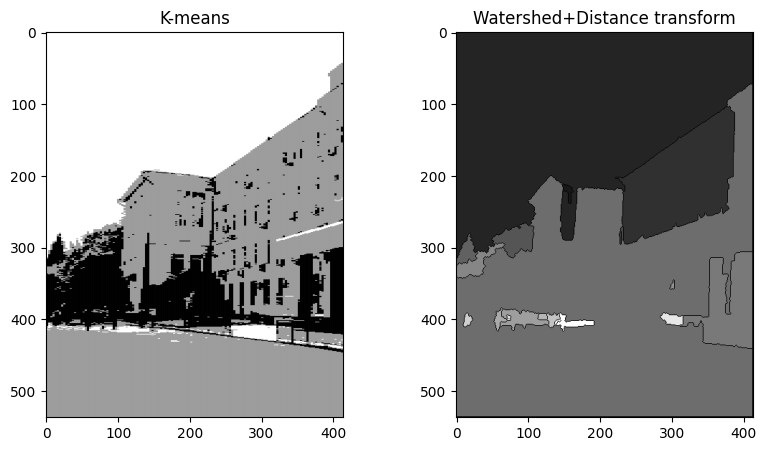

In [9]:
#K-means

flags = cv2.KMEANS_RANDOM_CENTERS

z = img.reshape((-1,3))
z = np.float32(z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2),plt.imshow(res2, cmap="gray"), plt.title('K-means')

#Watershed+Distance transform

ret, thresh = cv2.threshold(img,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#plt.imshow(thresh, cmap="gray")

dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
#plt.imshow(dist, cmap="gray")

ret, sure_fg = cv2.threshold(dist, 0.2 * dist.max(), 255, cv2.THRESH_BINARY) 
#plt.imshow(sure_fg, cmap="gray")

sure_fg = sure_fg.astype(np.uint8)

ret, markers = cv2.connectedComponents(sure_fg) 

#plt.imshow(markers, cmap="gray")

markers = cv2.watershed(img_origin, markers)
plt.subplot(1, 3, 3), plt.imshow(markers, cmap="gray"), plt.title('Watershed+Distance transform')